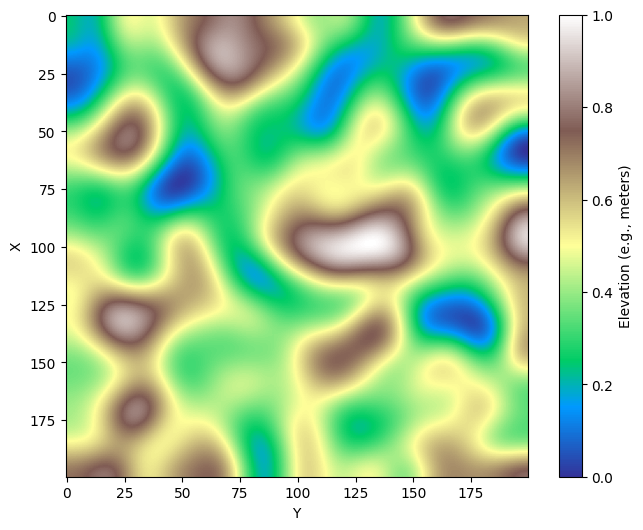

In [110]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random

# =============================
# 1. 数据生成与处理
# =============================

# 设置随机种子，保证可重复
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 定义图像尺寸和序列长度
IMG_H, IMG_W = 200, 200
SEQ_LEN = 20

# 生成一张固定的高程图（灰度值归一化到 [0,1]）
# 这里使用高斯滤波的随机噪声模拟地形
base_map = np.random.rand(IMG_H, IMG_W)
from scipy.ndimage import gaussian_filter
elevation_map = gaussian_filter(base_map, sigma=10)  # 平滑处理
elevation_map = elevation_map.astype(np.float32)
# 将图像归一化（可选步骤，这里数值本身已在 [0,1] 范围内）
elevation_map = (elevation_map - elevation_map.min()) / (elevation_map.max() - elevation_map.min())


# 可视化高程图
plt.figure(figsize=(8, 6))
plt.imshow(elevation_map, cmap='terrain')
plt.colorbar(label='Elevation (e.g., meters)')
plt.xlabel("Y")
plt.ylabel("X")
plt.show()


# CNN方案

In [111]:
def extract_trajectory_patch(elevation_map: np.ndarray, length, x, y, heading) -> np.ndarray:
    """通过航向确定轨迹"""
    rad = np.deg2rad(heading)
    dx = np.cos(rad)
    dy = -np.sin(rad)

    profile = []
    x_pos_list, y_pos_list = [], []
    for i in range(length):
        xi = int(round(x + i * dx))
        yi = int(round(y + i * dy))
        if 0 <= xi < elevation_map.shape[0] and 0 <= yi < elevation_map.shape[1]:
            profile.append(elevation_map[xi, yi])
            x_pos_list.append(xi)
            y_pos_list.append(yi)
        else:
            profile.append(np.nan)
            x_pos_list.append(np.nan)
            y_pos_list.append(np.nan)
    
    # 如果越界则直接弃用该样本
    if np.any(np.isnan(profile)):
        return None, None
    
    return (np.array(x_pos_list), np.array(y_pos_list)), np.array(profile) 

In [13]:
# 辅助函数：给定角度，计算通过图像中心的直线与边界的交点
def get_line_endpoints(center, angle):
    cx, cy = center
    # 计算参数 t，使得 (x=0 or x=IMG_W or y=0 or y=IMG_H)
    dx = np.cos(angle)
    dy = np.sin(angle)
    ts = []
    # 左边界 x=0
    if dx != 0:
        t = (0 - cx) / dx
        y = cy + t * dy
        if 0 <= y <= IMG_H:
            ts.append(t)
    # 右边界 x=IMG_W
    if dx != 0:
        t = (IMG_W - cx) / dx
        y = cy + t * dy
        if 0 <= y <= IMG_H:
            ts.append(t)
    # 底边界 y=0
    if dy != 0:
        t = (0 - cy) / dy
        x = cx + t * dx
        if 0 <= x <= IMG_W:
            ts.append(t)
    # 顶边界 y=IMG_H
    if dy != 0:
        t = (IMG_H - cy) / dy
        x = cx + t * dx
        if 0 <= x <= IMG_W:
            ts.append(t)
    if not ts:
        return None
    t_min = min(ts)
    t_max = max(ts)
    # 两个端点坐标
    p1 = (cx + t_min * dx, cy + t_min * dy)
    p2 = (cx + t_max * dx, cy + t_max * dy)
    return p1, p2

# 辅助函数：沿直线均匀采样 N 个点，获取高度值（双线性插值）并加噪声
def sample_line(elevation_map, N):
    """返回采样序列的坐标和带噪声的高程值。"""
    H, W = elevation_map.shape
    center = (W/2, H/2)
    # 随机选角度
    angle = random.uniform(0, 2*np.pi)
    endpoints = get_line_endpoints(center, angle)
    if endpoints is None:
        return None  # 若意外未交到边界（理论上不会发生）
    (x1, y1), (x2, y2) = endpoints
    # 均匀采样 N 个点
    xs = np.linspace(x1, x2, N)
    ys = np.linspace(y1, y2, N)
    # 双线性插值获取高度值
    # 限制采样点在图像范围内
    xs_clip = np.clip(xs, 0, W-1)
    ys_clip = np.clip(ys, 0, H-1)
    # 整数和小数部分
    x0 = np.floor(xs_clip).astype(int)
    y0 = np.floor(ys_clip).astype(int)
    x1i = np.ceil(xs_clip).astype(int)
    y1i = np.ceil(ys_clip).astype(int)
    # 插值权重
    dx = xs_clip - x0
    dy = ys_clip - y0
    heights = ( (1-dx)*(1-dy)*elevation_map[y0, x0] +
                dx*(1-dy)*elevation_map[y0, x1i] +
                (1-dx)*dy*elevation_map[y1i, x0] +
                dx*dy*elevation_map[y1i, x1i] )
    # 加入高斯噪声
    noise = np.random.normal(scale=0.01, size=heights.shape)
    heights_noisy = heights + noise
    return (xs, ys), heights_noisy 

# 测试采样函数，获取一个序列示例
(coord_seq, height_seq) = sample_line(elevation_map, SEQ_LEN)
# coord_seq 是两个数组 (xs, ys)，height_seq 是对应的高度值序列


In [112]:
# 构建训练集
NUM_TRAIN = 5000
NUM_TEST = 200

train_seqs = []
train_coords = []
for _ in range(NUM_TRAIN):
    x = random.random()*IMG_W
    y = random.random()*IMG_H
    heading = random.random()*0

    sample = extract_trajectory_patch(elevation_map, length=20, x=x, y=y, heading=heading)
    if sample[1] is None:
        continue
    (xs, ys), heights = sample
    train_seqs.append(heights.astype(np.float32))
    # 保存真实坐标并归一化到 [0,1]
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)  # shape (N,2)
    train_coords.append(coords_norm.astype(np.float32))


In [113]:
test_seqs = []
test_coords = []
for _ in range(NUM_TEST):
    x = random.random()*IMG_W
    y = random.random()*IMG_H
    heading = random.random()*0

    sample = extract_trajectory_patch(elevation_map, length=20, x=x, y=y, heading=heading)
    if sample[1] is None:
        continue
    (xs, ys), heights = sample
    test_seqs.append(heights.astype(np.float32))
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)
    test_coords.append(coords_norm.astype(np.float32))

train_seqs = np.array(train_seqs)   # shape (NUM_TRAIN, N)
train_coords = np.array(train_coords)  # shape (NUM_TRAIN, N, 2)
test_seqs = np.array(test_seqs)
test_coords = np.array(test_coords)


In [82]:
train_coords.shape

(4492, 20, 2)

In [89]:
# 转换为 PyTorch 的 TensorDataset
# 图像输入在每次训练中相同，可直接在训练循环中使用同一个 elevation_map_tensor
elevation_map_tensor = torch.tensor(elevation_map).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

train_seq_tensor = torch.tensor(train_seqs)        # (NUM_TRAIN, N)
train_coords_tensor = torch.tensor(train_coords)   # (NUM_TRAIN, N, 2)
test_seq_tensor = torch.tensor(test_seqs)
test_coords_tensor = torch.tensor(test_coords)

# 为便于 DataLoader 处理，将序列与坐标展平
train_seq_tensor = train_seq_tensor.unsqueeze(1)  # (NUM_TRAIN, 1, N)
test_seq_tensor = test_seq_tensor.unsqueeze(1)

# 建立 Dataset（图像用全局固定图像）
train_dataset = TensorDataset(train_seq_tensor, train_coords_tensor)
test_dataset = TensorDataset(test_seq_tensor, test_coords_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


# =============================
# 2. 模型定义：融合CNN和序列输入
# =============================

class FusionNet(nn.Module):
    def __init__(self, img_h, img_w, seq_len):
        super(FusionNet, self).__init__()
        self.img_h, self.img_w = img_h, img_w
        self.seq_len = seq_len
        # 图像卷积分支：输入 (B,1,H,W) -> 特征向量
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 输出 (B,16,H,W)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,16,H/2,W/2)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (B,32,H/2,W/2)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,32,H/4,W/4)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B,64,H/4,W/4)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # (B,64,1,1)
        )
        # 将 CNN 输出展平
        self.cnn_fc = nn.Linear(64, 128)  # (B,128)
        
        # 序列分支：输入 (B,1,N) -> 特征向量
        self.seq_net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  # (B,16,N)
            nn.ReLU(),
            nn.MaxPool1d(2),  # (B,16,N/2)
            nn.Conv1d(16, 32, kernel_size=3, padding=1),  # (B,32,N/2)
            nn.ReLU(),
            nn.MaxPool1d(2),  # (B,32,N/4)
            nn.Flatten(),     # (B, 32*(N/4))
        )
        # 计算序列分支输出维度
        dummy_input = torch.zeros(1, 1, seq_len)
        seq_feat_dim = self.seq_net(dummy_input).shape[1]
        self.seq_fc = nn.Linear(seq_feat_dim, 128)  # (B,128)
        
        # 最终融合：将两个特征拼接后预测 2*N 个坐标值
        self.final_fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2*seq_len)  # 输出长度为 2*N
        )

    def forward(self, img, seq):
        # 图像分支
        x = self.cnn(img)           # (B,64,1,1)
        x = x.view(x.size(0), -1)   # (B,64)
        x = self.cnn_fc(x)          # (B,128)
        # 序列分支
        s = self.seq_net(seq)       # (B, 32*(N/4))
        s = self.seq_fc(s)          # (B,128)
        # 特征融合
        feat = torch.cat([x, s], dim=1)  # (B,256)
        out = self.final_fc(feat)        # (B, 2*N)
        # reshape 输出为 (B,N,2) 方便理解
        out = out.view(-1, self.seq_len, 2)
        return out

# 实例化模型、定义损失与优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet(IMG_H, IMG_W, 20).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# =============================
# 3. 模型训练
# =============================

num_epochs = 20
print("开始训练...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_seq, batch_coords in train_loader:
        # batch_seq: (B,1,N)， batch_coords: (B,N,2)
        batch_size = batch_seq.size(0)
        # 准备图像输入（固定图像重复 B 次）
        imgs = elevation_map_tensor.expand(batch_size, -1, -1, -1).to(device)  # (B,1,H,W)
        seqs = batch_seq.to(device)
        targets = batch_coords.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs, seqs)  # (B,N,2)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] 平均损失: {avg_loss:.6f}")

print("训练完成。")


AttributeError: module 'torch.nn' has no attribute 'MAELoss'

In [84]:
# =============================
# 4. 模型测试与结果展示
# =============================

model.eval()
with torch.no_grad():
    total_mse = 0.0
    for batch_seq, batch_coords in test_loader:
        batch_size = batch_seq.size(0)
        imgs = elevation_map_tensor.expand(batch_size, -1, -1, -1).to(device)
        seqs = batch_seq.to(device)
        targets = batch_coords.to(device)
        outputs = model(imgs, seqs)
        total_mse += criterion(outputs, targets).item()
    avg_mse = total_mse / len(test_loader)
    print(f"测试集上的平均 MSE: {avg_mse:.6f}")

# 显示部分预测结果示例
print("\n示例预测:")
# 从测试集随机选择一个样本查看坐标预测
idx = random.randint(0, len(test_seqs)-1)
sample_seq = torch.tensor(test_seqs[idx]).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,N)
with torch.no_grad():
    pred = model(elevation_map_tensor.to(device), sample_seq)  # (1,N,2)
pred = pred.squeeze(0).cpu().numpy()  # (N,2)
truth = test_coords[idx]  # (N,2)

# 打印前10个点的真实 vs 预测坐标（已归一化到 [0,1]）
for i in range(10):
    tx, ty = truth[i]
    px, py = pred[i]
    print(f"点 {i}: 真实 ({tx:.3f}, {ty:.3f}) -> 预测 ({px:.3f}, {py:.3f})")


测试集上的平均 MSE: 0.066354

示例预测:
点 0: 真实 (0.400, 0.925) -> 预测 (0.587, 0.475)
点 1: 真实 (0.405, 0.925) -> 预测 (0.598, 0.474)
点 2: 真实 (0.410, 0.925) -> 预测 (0.599, 0.474)
点 3: 真实 (0.415, 0.925) -> 预测 (0.602, 0.470)
点 4: 真实 (0.420, 0.925) -> 预测 (0.613, 0.478)
点 5: 真实 (0.425, 0.925) -> 预测 (0.616, 0.474)
点 6: 真实 (0.430, 0.925) -> 预测 (0.619, 0.473)
点 7: 真实 (0.435, 0.925) -> 预测 (0.627, 0.471)
点 8: 真实 (0.440, 0.925) -> 预测 (0.630, 0.474)
点 9: 真实 (0.445, 0.925) -> 预测 (0.637, 0.474)


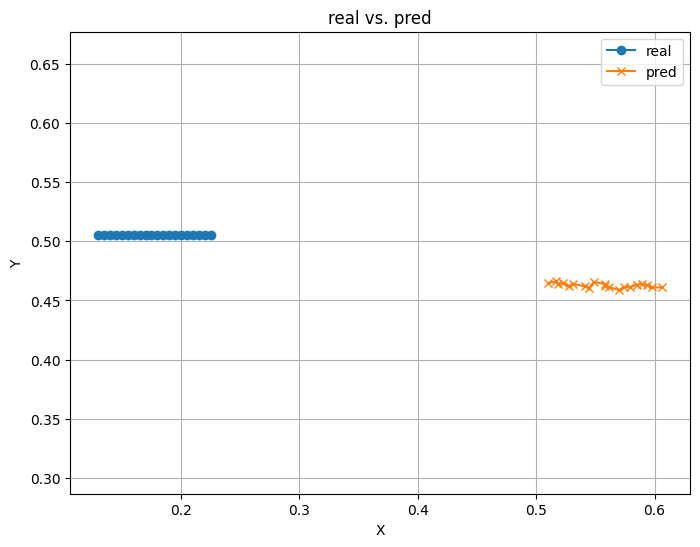

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 设：model 是训练好的模型，test_loader 是测试集数据加载器

# 1. 随机获取一条测试样本
sample_input, sample_target = next(iter(test_loader))  # 获取一个 batch
sample_input = sample_input[2].unsqueeze(0)  # [1, seq_len, feature_dim]
sample_target = sample_target[0]  # [seq_len, output_dim]

# 2. 预测
model.eval()
with torch.no_grad():
    prediction = model(elevation_map_tensor.to(device), sample_input)  # [1, seq_len, output_dim]
    prediction = prediction.squeeze(0).cpu().numpy()

# 3. 提取真实轨迹
true_trajectory = sample_target.cpu().numpy()

# 4. 可视化
plt.figure(figsize=(8, 6))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], label='real', marker='o')
plt.plot(prediction[:, 0], prediction[:, 1], label='pred', marker='x')
plt.title('real vs. pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Transform方案

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

# =============================
# 1. 数据生成与处理
# =============================
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

IMG_H, IMG_W = 100, 100
SEQ_LEN = 50
NUM_TRAIN, NUM_TEST = 1000, 200

# 固定高程图
base_map = np.random.rand(IMG_H, IMG_W)
elevation_map = gaussian_filter(base_map, sigma=10).astype(np.float32)
elevation_map = (elevation_map - elevation_map.min()) / (elevation_map.max() - elevation_map.min())

# 生成坐标通道
xs = np.linspace(0,1,IMG_W)
ys = np.linspace(0,1,IMG_H)
grid_x, grid_y = np.meshgrid(xs, ys)
coord_map = np.stack([elevation_map, grid_x, grid_y], axis=0).astype(np.float32)  # (3,H,W)
coord_map_tensor = torch.tensor(coord_map).unsqueeze(0)  # (1,3,H,W)

def get_line_endpoints(center, angle):
    cx, cy = center
    dx, dy = np.cos(angle), np.sin(angle)
    ts = []
    for edge in [(0,None),(IMG_W,None),(None,0),(None,IMG_H)]:
        if edge[0] is not None:
            t = (edge[0] - cx)/dx if dx!=0 else None
            y = cy + t*dy if t is not None else None
            if t is not None and 0<=y<=IMG_H: ts.append(t)
        else:
            t = (edge[1] - cy)/dy if dy!=0 else None
            x = cx + t*dx if t is not None else None
            if t is not None and 0<=x<=IMG_W: ts.append(t)
    if not ts: return None
    tmin,tmax = min(ts), max(ts)
    return (cx+tmin*dx, cy+tmin*dy),(cx+tmax*dx, cy+tmax*dy)

def sample_line(elev_map, N):
    center = (IMG_W/2, IMG_H/2)
    angle = random.uniform(0,2*np.pi)
    endpoints = get_line_endpoints(center, angle)
    if endpoints is None: return None
    (x1,y1),(x2,y2) = endpoints
    xs = np.linspace(x1,x2,N)
    ys = np.linspace(y1,y2,N)
    # 双线性插值
    xs_c = np.clip(xs,0,IMG_W-1); ys_c=np.clip(ys,0,IMG_H-1)
    x0,y0 = np.floor(xs_c).astype(int), np.floor(ys_c).astype(int)
    x1i,y1i = np.ceil(xs_c).astype(int), np.ceil(ys_c).astype(int)
    dx = xs_c-x0; dy=ys_c-y0
    h00 = elev_map[y0, x0]; h10=elev_map[y0, x1i]
    h01 = elev_map[y1i, x0]; h11=elev_map[y1i, x1i]
    heights = (1-dx)*(1-dy)*h00 + dx*(1-dy)*h10 + (1-dx)*dy*h01 + dx*dy*h11
    heights += np.random.normal(scale=0.01, size=heights.shape)
    xs_norm = xs/IMG_W; ys_norm=ys/IMG_H
    coords = np.stack([xs_norm, ys_norm], axis=1)
    return heights.astype(np.float32), coords.astype(np.float32)

# 构造数据集
def build_dataset(num_samples):
    seqs, coords = [], []
    while len(seqs)<num_samples:
        out = sample_line(elevation_map, SEQ_LEN)
        if out is None: continue
        h, c = out
        seqs.append(h); coords.append(c)
    return np.array(seqs), np.array(coords)

train_seqs, train_coords = build_dataset(NUM_TRAIN)
test_seqs, test_coords   = build_dataset(NUM_TEST)

train_loader = DataLoader(TensorDataset(
    torch.tensor(train_seqs).unsqueeze(1),
    torch.tensor(train_coords)
), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(
    torch.tensor(test_seqs).unsqueeze(1),
    torch.tensor(test_coords)
), batch_size=32)

# =============================
# 2. 模型定义：CoordConv + Attention
# =============================
class AttentionMatcher(nn.Module):
    def __init__(self, img_h, img_w, seq_len, d_model=64):
        super().__init__()
        self.seq_len = seq_len
        # 图像 backbone: CoordConv
        self.cnn = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,d_model,3,padding=1), nn.ReLU()
        )
        # 序列 encoder
        self.seq_net = nn.Sequential(
            nn.Conv1d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Flatten(), nn.Linear((seq_len//4)*32, d_model)
        )
        # 位置 embedding for spatial bins
        H4, W4 = img_h//4, img_w//4
        self.register_buffer('spatial_coords',
            torch.stack(torch.meshgrid(
                torch.linspace(0,1,W4), torch.linspace(0,1,H4)
            ),-1).view(-1,2) # (H4*W4,2)
        )
        # final scaling
        self.to_out = nn.Linear(d_model,1)

    def forward(self, img, seq):
        B = seq.size(0)
        # image features
        feat = self.cnn(img)  # (B,d_model,H4,W4)
        B, D, H4, W4 = feat.shape
        kv = feat.view(B, D, -1).permute(0,2,1)  # (B,HW,D)
        # sequence feature
        q = self.seq_net(seq)  # (B, d_model)
        q = q.unsqueeze(1).expand(-1, self.seq_len, -1)  # (B,N,D)
        # attention scores
        scores = torch.matmul(q, kv.transpose(1,2)) / np.sqrt(D)  # (B,N,HW)
        attn = torch.softmax(scores, dim=-1)  # (B,N,HW)
        # predict coords by weighted sum of spatial bins
        coords = torch.matmul(attn, self.spatial_coords)  # (B,N,2)
        return coords

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionMatcher(IMG_H, IMG_W, SEQ_LEN).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# =============================
# 3. 训练
# =============================
for epoch in range(15):
    model.train()
    total_loss=0
    for seqs, coords in train_loader:
        B=seqs.size(0)
        imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
        seqs, coords = seqs.to(device), coords.to(device)
        pred = model(imgs, seqs)
        loss = criterion(pred, coords)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss={total_loss/len(train_loader):.6f}")


Epoch 1, Loss=0.055051
Epoch 2, Loss=0.055050
Epoch 3, Loss=0.055062
Epoch 4, Loss=0.054926
Epoch 5, Loss=0.054862
Epoch 6, Loss=0.054988
Epoch 7, Loss=0.054887
Epoch 8, Loss=0.055263
Epoch 9, Loss=0.054950
Epoch 10, Loss=0.055058
Epoch 11, Loss=0.054957
Epoch 12, Loss=0.054907
Epoch 13, Loss=0.054870
Epoch 14, Loss=0.055033
Epoch 15, Loss=0.055221


[16.17276  17.553463 18.934166 20.314869 21.695574 23.076277 24.456982
 25.837685 27.21839  28.599092 29.979795 31.3605   32.741203 34.121906
 35.50261  36.883316 38.26402  39.644722 41.02543  42.406128 43.78683
 45.167534 46.54824  47.928944 49.309647 50.690353 52.071053 53.45176
 54.832466 56.213165 57.593872 58.974575 60.355274 61.73598  63.116688
 64.49739  65.87809  67.2588   68.639496 70.0202   71.40091  72.78161
 74.162315 75.543015 76.92372  78.30443  79.68513  81.065834 82.44654
 83.82724 ] [  0.          2.0408163   4.0816326   6.122449    8.163265   10.204082
  12.244898   14.285715   16.32653    18.367348   20.408163   22.448978
  24.489796   26.530611   28.57143    30.612246   32.65306    34.69388
  36.734695   38.77551    40.816326   42.857143   44.897957   46.938778
  48.97959    51.02041    53.061222   55.10204    57.14286    59.183674
  61.22449    63.265305   65.30612    67.34694    69.38776    71.42857
  73.46939    75.5102     77.55102    79.591835   81.63265    83.

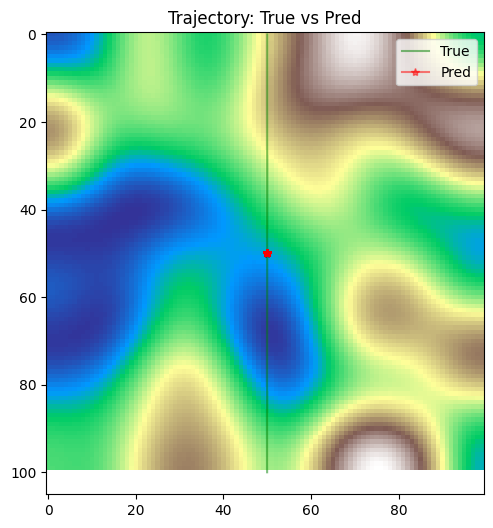

In [96]:
# =============================
# 4. 可视化测试示例
# =============================
model.eval()
with torch.no_grad():
    seqs, coords = next(iter(test_loader))
    B=seqs.size(0)
    imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
    pred = model(imgs, seqs.to(device)).cpu().numpy()
    true = coords.numpy()

print(true[idx,:,0]*IMG_W, true[idx,:,1]*IMG_H)
print(pred[idx,:,0]*IMG_W, pred[idx,:,1]*IMG_H)

# 随机展示一个样本
idx = random.randrange(B)
plt.figure(figsize=(6,6))
plt.imshow(elevation_map, cmap='terrain')
plt.plot(true[idx,:,0]*IMG_W, true[idx,:,1]*IMG_H, 'g-', label='True', alpha=0.5)
plt.plot(pred[idx,:,0]*IMG_W, pred[idx,:,1]*IMG_H, 'r*-', label='Pred', alpha=0.5)
plt.legend()
plt.title("Trajectory: True vs Pred")
plt.show()

In [114]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter

# =============================
# 1. 数据准备（同前）
# =============================
# np.random.seed(0); torch.manual_seed(0); random.seed(0)
# IMG_H, IMG_W, SEQ_LEN = 200, 200, 20
# NUM_TRAIN, NUM_TEST = 5000, 500

# 固定 DEM
# base_map = np.random.rand(IMG_H, IMG_W)
# elevation_map = gaussian_filter(base_map, sigma=10).astype(np.float32)
# elevation_map = (elevation_map - elevation_map.min())/(elevation_map.max()-elevation_map.min())

# 生成 CoordConv 输入
xs = np.linspace(0,1,IMG_W); ys = np.linspace(0,1,IMG_H)
grid_x, grid_y = np.meshgrid(xs, ys)
coord_map = np.stack([elevation_map, grid_x, grid_y],0).astype(np.float32)
coord_map_tensor = torch.tensor(coord_map).unsqueeze(0)  # (1,3,H,W)

# # 采样工具（略，与前同）
# def get_line_endpoints(center, angle):
#     cx, cy = center; dx, dy = np.cos(angle), np.sin(angle)
#     ts=[] 
#     for X in (0,IMG_W):
#         if dx!=0:
#             t=(X-cx)/dx; y=cy+t*dy
#             if 0<=y<=IMG_H: ts.append(t)
#     for Y in (0,IMG_H):
#         if dy!=0:
#             t=(Y-cy)/dy; x=cx+t*dx
#             if 0<=x<=IMG_W: ts.append(t)
#     if not ts: return None
#     t0,t1=min(ts),max(ts)
#     return (cx+t0*dx, cy+t0*dy),(cx+t1*dx, cy+t1*dy)

# def sample_line(elev_map, N):
#     center=(IMG_W/2, IMG_H/2)
#     angle=random.uniform(0,2*np.pi)
#     pts=get_line_endpoints(center, angle)
#     if pts is None: return None
#     (x0,y0),(x1,y1)=pts
#     xs=np.linspace(x0,x1,N); ys=np.linspace(y0,y1,N)
#     xs_c=np.clip(xs,0,IMG_W-1); ys_c=np.clip(ys,0,IMG_H-1)
#     x0i,y0i = np.floor(xs_c).astype(int), np.floor(ys_c).astype(int)
#     x1i,y1i = np.ceil(xs_c).astype(int), np.ceil(ys_c).astype(int)
#     dx=xs_c-x0i; dy=ys_c-y0i
#     h00=elev_map[y0i,x0i]; h10=elev_map[y0i,x1i]
#     h01=elev_map[y1i,x0i]; h11=elev_map[y1i,x1i]
#     heights=(1-dx)*(1-dy)*h00 + dx*(1-dy)*h10 + (1-dx)*dy*h01 + dx*dy*h11
#     heights+=np.random.normal(scale=0.01,size=heights.shape)
#     coords=np.stack([xs/IMG_W, ys/IMG_H],1).astype(np.float32)
#     return heights.astype(np.float32), coords

# def build_dataset(n):
#     seqs, coords = [], []
#     while len(seqs)<n:
#         out=sample_line(elevation_map, SEQ_LEN)
#         if out is None: continue
#         h,c=out
#         seqs.append(h); coords.append(c)
#     return np.array(seqs), np.array(coords)

# train_seqs, train_coords = build_dataset(NUM_TRAIN)
# test_seqs,  test_coords  = build_dataset(NUM_TEST)

train_ds = TensorDataset(
    torch.tensor(train_seqs).unsqueeze(1),
    torch.tensor(train_coords)
)
test_ds = TensorDataset(
    torch.tensor(test_seqs).unsqueeze(1),
    torch.tensor(test_coords)
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [120]:
# =============================
# 2. 模型：CoordConv + Attention
# =============================
class AttentionMatcher(nn.Module):
    def __init__(self, H, W, N, d_model=64):
        super().__init__()
        self.N = N
        # CoordConv backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,d_model,3,padding=1), nn.ReLU()
        )
        # Sequence encoder: 保留时序维度
        self.seq_net = nn.Sequential(
            nn.Conv1d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16,d_model,3,padding=1), nn.ReLU(),
            nn.Upsample(size=N, mode='linear', align_corners=False)  # 恢复到长度 N
        )
        # 下采样特征图尺寸
        H4, W4 = H//4, W//4
        # 生成特征图对应的归一化坐标 (HW,2)
        ys = torch.linspace(0,1,H4); xs = torch.linspace(0,1,W4)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        self.register_buffer('spatial_coords', torch.stack([grid_x, grid_y],-1).view(-1,2))  # (HW,2)

    def forward(self, img, seq):
        B = seq.size(0)
        # 图像特征 (B,d,H4,W4)
        feat = self.cnn(img)
        B, D, H4, W4 = feat.shape
        # Flatten 空间 -> (B, HW, D)
        kv = feat.view(B, D, -1).permute(0,2,1)
        # 序列特征 -> (B, D, N) -> 转置为 (B, N, D)
        s = self.seq_net(seq)  # (B,d,N)
        q = s.permute(0,2,1)    # (B,N,d)
        # Attention
        scores = torch.matmul(q, kv.transpose(1,2)) / np.sqrt(D)  # (B,N,HW)
        attn   = torch.softmax(scores, dim=-1)
        # Weighted sum得到坐标 (B,N,2)
        coords = torch.matmul(attn, self.spatial_coords)  
        return coords

# 实例化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionMatcher(IMG_H, IMG_W, N=20).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [121]:
# =============================
# 3. 训练
# =============================
for epoch in range(50):
    model.train()
    total=0
    for seqs, coords in train_loader:
        B=seqs.size(0)
        imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
        seqs, coords = seqs.to(device), coords.to(device)
        out = model(imgs, seqs)
        loss=criterion(out, coords)
        opt.zero_grad(); loss.backward(); opt.step()
        total+=loss.item()
    print(f"Epoch {epoch+1}, loss={total/len(train_loader):.5f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (640x2500 and 40000x2)

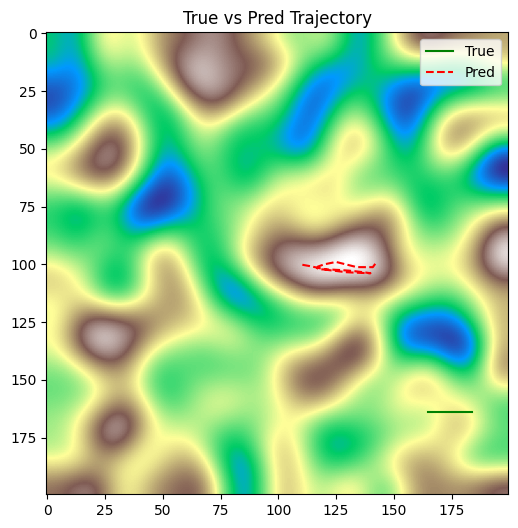

In [119]:

# =============================
# 4. 可视化
# =============================
model.eval()
with torch.no_grad():
    seqs, coords = next(iter(test_loader))
    B=seqs.size(0)
    imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
    pred = model(imgs, seqs.to(device)).cpu().numpy()
    true=coords.numpy()

idx = random.randrange(B)
plt.figure(figsize=(6,6))
plt.imshow(elevation_map, cmap='terrain')
# 真实 vs 预测，乘回像素坐标
tx = true[idx,:,0]*IMG_W; ty=true[idx,:,1]*IMG_H
px = pred[idx,:,0]*IMG_W; py=pred[idx,:,1]*IMG_H
plt.plot(tx, ty, 'g-', label='True')
plt.plot(px, py, 'r--', label='Pred')
plt.legend(); plt.title("True vs Pred Trajectory"); plt.show()